<a href="https://colab.research.google.com/github/zichenghuang/spam-email-detection/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

#Import Data

The data consists of examples of spam and non-spam emails, of which there are 4600 labeled examples. The feature vector $x$ is a 54-dimensional vector extracted from the email and $y=1$ indicates a spam email.

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# import data
X = pd.read_csv('/gdrive/MyDrive/Repository/spam_email_detection/data/X.csv', 
                sep=',', 
                header=None)

y = pd.read_csv('/gdrive/MyDrive/Repository/spam_email_detection/data/y.csv', 
                sep=',', 
                header=None)

# Logistic Regression w/ Steepest Ascent Algorithm

In every experiment below, we randomly partition the data into 10 folds and run the algorithm 10 different times so that each fold is held out as a test set one time. The final result we show is the cumulative result across these 10 folds.

We first implement the logistic regression with steepest ascent algorithm using a step size of $\frac{0.01}{4600}$. In order to adjust to the prediction of logistic regression, we set every $y_i=0$ to $y_i = -1$, and we add an extra dimention euql to $+1$ to each data point to account for the intercept term. We run the algorithm for $1,000$ iterations and plot the logistic regression objective training function $\mathcal{L}$ per iteration for each of the 10 training runs.

## Implement and trian the model


In [4]:
# steepest ascent logistic classifier
def pred_logistic(X, y, 
                  n_folds=10,
                  shuffle_data = True,
                  n_iterations = 1000,
                  step_size = 0.01 / 4600):

    input_X = np.array(X)
    input_X = np.hstack((input_X, np.ones((len(input_X), 1), dtype=int)))

    input_y = np.array(y)
    indices = np.nonzero(input_y == 0)
    input_y[indices[0]] = int(-1)

    plt.figure(figsize=(10, 8))
    plt.title('logistic regression objective training function per iteration')
    plt.xlabel('iteration #')
    plt.ylabel('objective training function: L')

    true_negative = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0

    kf = KFold(n_splits=n_folds, shuffle=shuffle_data)

    for train_index, test_index in kf.split(input_X):

        X_test = input_X[test_index]
        y_test = input_y[test_index]
        X_train = input_X[train_index]
        y_train = input_y[train_index]

        w = np.zeros((X_train.shape[1], 1))
        L = np.zeros(n_iterations)

        for t in range(n_iterations):
            
            sigmoid = np.exp(y_train * X_train @ w) / (1 + np.exp(y_train * X_train @ w))
            gradient = np.sum((1 - sigmoid) * y_train * X_train, axis=0).reshape(-1, 1)
            w += step_size * gradient
            L[t] = np.sum(np.log(sigmoid))
        
        plt.plot(np.arange(n_iterations), L)

        y_pred = X_test @ w
        indices_positive = np.nonzero(y_pred > 0)[0]
        indices_negative = np.nonzero(y_pred < 0)[0]
        y_pred[indices_positive] = 1
        y_pred[indices_negative] = -1

        true_negative += np.nonzero((y_pred == -1) & (y_test == -1))[0].shape[0]
        true_positive += np.nonzero((y_pred == 1) & (y_test == 1))[0].shape[0]
        false_negative += np.nonzero((y_pred == -1) & (y_test == 1))[0].shape[0]
        false_positive += np.nonzero((y_pred == 1) & (y_test == -1))[0].shape[0]

        correct = true_negative + true_positive
        total = true_negative + true_positive + false_negative + false_positive
        accuracy = correct / total

    return true_negative, true_positive, false_negative, false_positive, accuracy

## Plot the objective training function $\mathcal{L}$ per iteration for each of the 10 folds

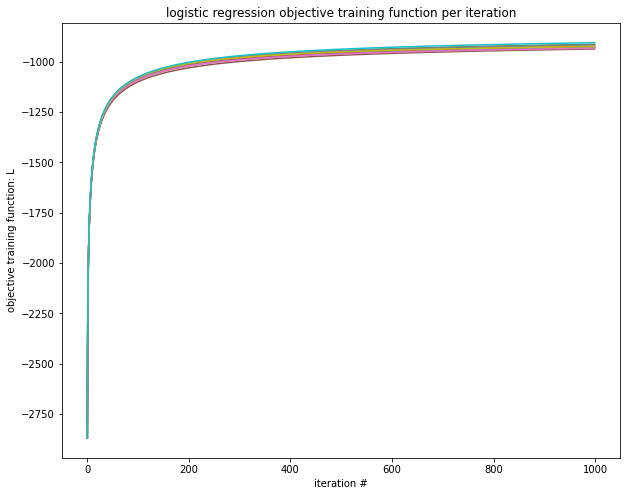

In [5]:
# plot the logistic regression objective trainning function
tn, tp, fn, fp, accuracy = pred_logistic(X, y, 
                                         n_folds=10, 
                                         shuffle_data = True,
                                         n_iterations = 1000, 
                                         step_size = 0.01/4600)

## Plot the confusion matrix and prediction accuracy

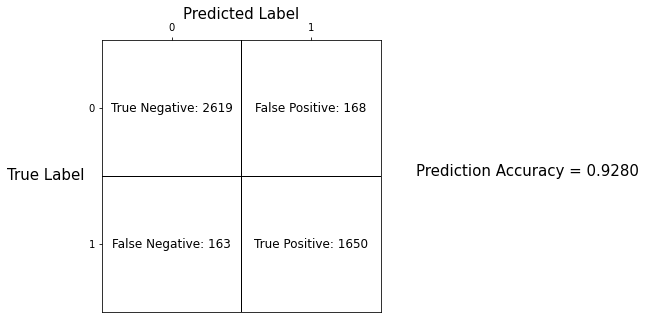

In [6]:
# 2 by 2 table of steepest ascent algorithm prediction results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot the 2 by 2 table
ax.plot([-0.5, 1.5], [0.5, 0.5], '-k', lw=1)
ax.plot([0.5, 0.5], [-0.5, 1.5], '-k', lw=1)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(1.5,-0.5)

# set xlabels
ax.set_xlabel('Predicted Label', fontsize=15)
ax.set_xticks([0, 1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# set ylabels
ax.set_ylabel('True Label', fontsize=15, rotation=0)
ax.set_yticks([0, 1])
ax.yaxis.set_label_coords(-0.2, 0.475)

# fill in the 2 by 2 table
ax.text(0, 0, 'True Negative: %d'%(tn),va='center', ha='center', fontsize=12)
ax.text(0, 1, 'False Negative: %d'%fn,va='center', ha='center', fontsize=12)
ax.text(1, 0, 'False Positive: %d'%fp,va='center', ha='center', fontsize=12)
ax.text(1, 1, 'True Positive: %d'%(tp),va='center', ha='center', fontsize=12)
ax.text(1.75, 0.5, 'Prediction Accuracy = {:.4f}'.format(accuracy), fontsize=15)

plt.show()

# Logistic Regression w/ Newton's Method

We then try to use Newton's Method to modify the logistic regression algorithm in that at iteration $t$ we approximate the function:
$$
\mathcal{L}\approx \mathcal{L}'(w)\equiv\mathcal{L}(w_t)+(w-w_t)^{T}\nabla\mathcal{L}(w_t)+\frac{1}{2}(w-w_t)^{T}\nabla^{2}\mathcal{L}(w_t)(w-w_t)
$$
At iteration $t$, we then set $w_{t+1}=\arg\max_{w}\mathcal{L}'(w)$. We also plot the objection function $\mathcal{L}$ on the training data as a function of iteration $t = 1, \dots, 100$ for each of the 10 training runs.

## Implement and trian the model


In [7]:
# Newton's method algorithm
def pred_newton(X, y, n_folds = 10, shuffle_data = True, n_iterations = 100):

    plt.figure(figsize=(10, 8))
    plt.title("Newton's method objective training function per iteration")
    plt.xlabel('iteration #')
    plt.ylabel('objective training function: L')

    input_X = np.array(X)
    input_X = np.hstack((input_X, np.ones((len(input_X), 1), dtype=int)))

    input_y = np.array(y)
    indices = np.nonzero(input_y == 0)
    input_y[indices[0]] = int(-1)

    true_negative = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0

    kf = KFold(n_splits=n_folds, shuffle=shuffle_data)

    for train_index, test_index in kf.split(input_X):

        X_test = input_X[test_index]
        y_test = input_y[test_index]
        X_train = input_X[train_index]
        y_train = input_y[train_index]

        w = np.zeros((X_train.shape[1], 1))
        L = np.zeros(n_iterations)
        I = 0.01 * np.identity(X_train.shape[1])

        for t in range(n_iterations):
            
            sigmoid = np.exp(y_train * X_train @ w) / (1 + np.exp(y_train * X_train @ w))
            gradient = np.sum((1 - sigmoid) * y_train * X_train, axis=0).reshape(-1, 1)
            hessian = -1 * X_train.T @ (sigmoid * (1 - sigmoid) * X_train) - I
            w -= np.linalg.inv(hessian) @ gradient
            L[t] = np.sum(np.log(sigmoid))

        plt.plot(np.arange(n_iterations), L)

        y_pred = X_test @ w
        indices_positive = np.nonzero(y_pred > 0)[0]
        indices_negative = np.nonzero(y_pred < 0)[0]
        y_pred[indices_positive] = 1
        y_pred[indices_negative] = -1

        true_negative += np.nonzero((y_pred == -1) & (y_test == -1))[0].shape[0]
        true_positive += np.nonzero((y_pred == 1) & (y_test == 1))[0].shape[0]
        false_negative += np.nonzero((y_pred == -1) & (y_test == 1))[0].shape[0]
        false_positive += np.nonzero((y_pred == 1) & (y_test == -1))[0].shape[0]

        correct = true_negative + true_positive
        total = true_negative + true_positive + false_negative + false_positive
        accuracy = correct / total

    return true_negative, true_positive, false_negative, false_positive, accuracy

## Plot the objective training function $\mathcal{L}$ per iteration for each of the 10 folds

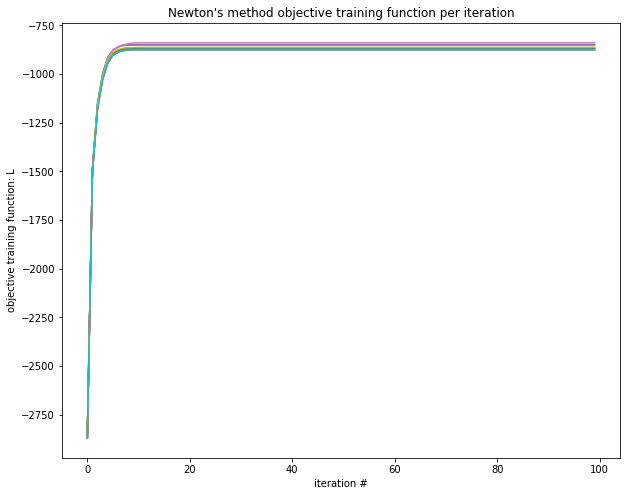

In [8]:
# plot the objective function using Newton's method
tn, tp, fn, fp, accuracy = pred_newton(X, y, n_folds = 10, shuffle_data = True, n_iterations = 100)

## Plot the confusion matrix and prediction accuracy

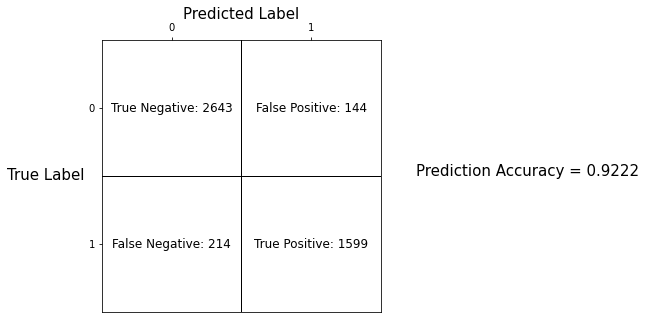

In [9]:
# 2 by 2 table of Newton's method prediction results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot the 2 by 2 table
ax.plot([-0.5, 1.5], [0.5, 0.5], '-k', lw=1)
ax.plot([0.5, 0.5], [-0.5, 1.5], '-k', lw=1)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(1.5,-0.5)

# set xlabels
ax.set_xlabel('Predicted Label', fontsize=15)
ax.set_xticks([0, 1])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# set ylabels
ax.set_ylabel('True Label', fontsize=15, rotation=0)
ax.set_yticks([0, 1])
ax.yaxis.set_label_coords(-0.2, 0.475)

# fill in the 2 by 2 table
ax.text(0, 0, 'True Negative: %d'%(tn),va='center', ha='center', fontsize=12)
ax.text(0, 1, 'False Negative: %d'%fn,va='center', ha='center', fontsize=12)
ax.text(1, 0, 'False Positive: %d'%fp,va='center', ha='center', fontsize=12)
ax.text(1, 1, 'True Positive: %d'%(tp),va='center', ha='center', fontsize=12)
ax.text(1.75, 0.5, 'Prediction Accuracy = {:.4f}'.format(accuracy), fontsize=15)

plt.show()